In [1]:
import os, sys

sys.path.append("..")

from gammabayes.BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.utils.utils import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools
from multiprocessing import Pool, freeze_support
import multiprocessing

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:

temp_true_log10e_axis = log10eaxistrue
temp_true_offset_axis = np.linspace(0,convertlonlat_to_offset(np.array([longitudeaxistrue[-1], latitudeaxistrue[-1]])),71)

rad_axis = np.logspace(-3,0.5,71)
migraaxis = np.logspace(-1,0.5, 91)
rad_axis = np.insert(rad_axis, 0, 0)

psf_mesh = np.meshgrid(rad_axis, temp_true_log10e_axis, temp_true_offset_axis, indexing='ij')
rad_axis



array([0.00000000e+00, 1.00000000e-03, 1.12201845e-03, 1.25892541e-03,
       1.41253754e-03, 1.58489319e-03, 1.77827941e-03, 1.99526231e-03,
       2.23872114e-03, 2.51188643e-03, 2.81838293e-03, 3.16227766e-03,
       3.54813389e-03, 3.98107171e-03, 4.46683592e-03, 5.01187234e-03,
       5.62341325e-03, 6.30957344e-03, 7.07945784e-03, 7.94328235e-03,
       8.91250938e-03, 1.00000000e-02, 1.12201845e-02, 1.25892541e-02,
       1.41253754e-02, 1.58489319e-02, 1.77827941e-02, 1.99526231e-02,
       2.23872114e-02, 2.51188643e-02, 2.81838293e-02, 3.16227766e-02,
       3.54813389e-02, 3.98107171e-02, 4.46683592e-02, 5.01187234e-02,
       5.62341325e-02, 6.30957344e-02, 7.07945784e-02, 7.94328235e-02,
       8.91250938e-02, 1.00000000e-01, 1.12201845e-01, 1.25892541e-01,
       1.41253754e-01, 1.58489319e-01, 1.77827941e-01, 1.99526231e-01,
       2.23872114e-01, 2.51188643e-01, 2.81838293e-01, 3.16227766e-01,
       3.54813389e-01, 3.98107171e-01, 4.46683592e-01, 5.01187234e-01,
      

## PSF

In [21]:

psfvals = psf_efficient(*psf_mesh)
psfvals.shape
longitudeaxistrue[-1]

3.5

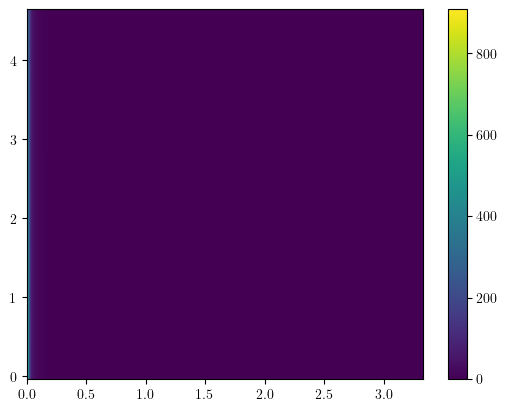

In [22]:

plt.figure()
plt.pcolormesh(rad_axis, temp_true_offset_axis, np.exp(np.max(psfvals,axis=1).T))
plt.colorbar()
plt.show()

In [23]:
psf_efficient_interpolator = interpolate.RegularGridInterpolator((rad_axis, temp_true_log10e_axis, temp_true_offset_axis,), np.exp(psfvals), method='nearest', bounds_error=False, 
                                                                 fill_value=0)
psf_efficient_interpolator_lambda = lambda input_tuple: np.log(psf_efficient_interpolator(input_tuple))

In [24]:
# %%timeit
meshgridvalues = np.meshgrid(0.0, 0.0, log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
gridvalues = (angularseparation(np.array([meshgridvalues[0].flatten(), meshgridvalues[1].flatten()]), np.array([meshgridvalues[3].flatten(), meshgridvalues[4].flatten()])),
              meshgridvalues[2].flatten(), 
              convertlonlat_to_offset(np.array([meshgridvalues[3].flatten(), meshgridvalues[4].flatten()])),)

In [25]:
%%timeit
new_psf_vals = psf_efficient_interpolator_lambda(gridvalues).reshape(meshgridvalues[0].shape)

81.4 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
new_psf_vals = np.squeeze(psf_efficient_interpolator_lambda(gridvalues).reshape(meshgridvalues[0].shape))

In [27]:
%%timeit

psfvals = psf_efficient(*gridvalues).reshape(meshgridvalues[0].shape)

419 ms ± 9.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
newnew_psf_vals = np.squeeze(psf_efficient_interpolator_lambda((*psf_mesh,)).reshape(psf_mesh[0].shape))


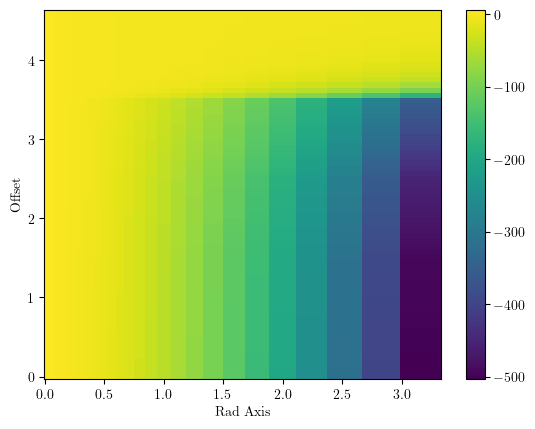

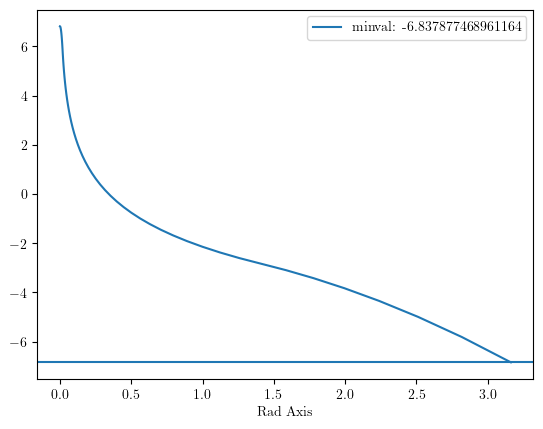

In [29]:
plt.figure()
plt.pcolormesh(rad_axis, temp_true_offset_axis, np.max(newnew_psf_vals, axis=1).T)
plt.xlabel('Rad Axis')
plt.ylabel('Offset')
plt.colorbar()
plt.show()

plt.figure()
plt.plot(rad_axis, np.max(newnew_psf_vals, axis=(1,2)))
minval = np.min(np.max(newnew_psf_vals, axis=(1,2)))
plt.axhline(minval, label=f"minval: {minval}")
plt.legend()
plt.xlabel('Rad Axis')
plt.show()

In [30]:
%%timeit

psfvals = psf_efficient(*psf_mesh)

2.13 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Energy Disp

In [31]:
edisp_mesh = np.meshgrid(migraaxis, temp_true_log10e_axis, temp_true_offset_axis, indexing='ij')


edispvals = edisp_migra(*edisp_mesh)
edispvals.shape


(91, 751, 71)

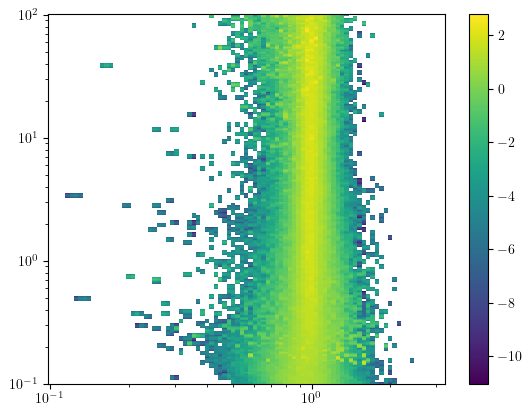

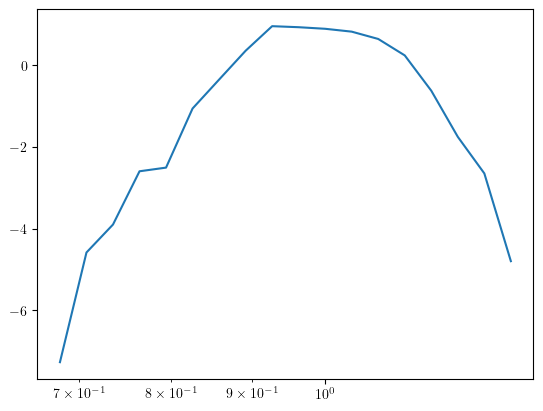

In [45]:
plt.figure()
plt.pcolormesh(migraaxis, 10**log10eaxistrue, np.max(edispvals,axis=2).T)
plt.loglog()
plt.colorbar()
plt.show()

plt.figure()
plt.plot(migraaxis, np.min(np.max(edispvals,axis=2), axis=1).T)
plt.xscale('log')
plt.show()

In [38]:
meshgridvalues = np.meshgrid(0.0, log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
edisp_gridvalues = (10**(meshgridvalues[0]-meshgridvalues[1]).flatten(),
              meshgridvalues[1].flatten(), 
              convertlonlat_to_offset(np.array([meshgridvalues[2].flatten(), meshgridvalues[3].flatten()])),)
edisp_gridvalues_v2 = (meshgridvalues[0].flatten(),
              meshgridvalues[1].flatten(), 
              meshgridvalues[2].flatten(), 
              meshgridvalues[3].flatten(),)

In [39]:
edisp_efficient_interpolator = interpolate.RegularGridInterpolator((migraaxis, temp_true_log10e_axis, temp_true_offset_axis,), np.exp(edispvals), method='nearest', bounds_error=False, 
                                                                 fill_value=0)
edisp_efficient_interpolator_lambda = lambda input_tuple: np.log(edisp_efficient_interpolator(input_tuple))

In [40]:
%%timeit
edispvals = edisp_test(*edisp_gridvalues_v2)

192 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%timeit
edisp_efficient_interpolator_lambda(edisp_gridvalues)

77.6 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
